In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
from popsims.galaxy import Pointing, volume_calc, create_pop
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] =20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.titlesize'] = 20

splat.initializeStandards(all=True)

%matplotlib inline



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/








In [2]:
import numpy
import shapey
import splat
import popsims

In [3]:
fig_folder='/users/caganze/research/popsims/figures/'
data_folder='/users/caganze/research/popsims/data/'

In [4]:
H=350
FOV={'jswt':220*(u.arcmin**2)*124}
#make magnitude cuts
grism_cuts={'JSWT':{'NIRISS_F200W':[1, 27.], 'NIRISS_F115W':[1, 27.],\
                    'NIRISS_F150W':[1, 27.] }}

#the goods north field
#OINTS={'jswt':SkyCoord(ra="12:36:55", dec="62:14:15", unit=(u.hourangle, u.deg))}
POINTS={'jswt':SkyCoord(l=np.random.uniform(-180, 180, 10 )*u.degree,\
               b=np.random.uniform(-90, 90, 10)*u.degree, frame='galactic')}

In [5]:
#local luminosity function
#LF=pd.read_pickle(popsims.DATA_FOLDER+'/lf_scales.pkl')

In [6]:
def scale_to_lf(data):
    scale=data.scale.iloc[0]
    return scale
        

def make_cuts(df,  cut_dict, survey='JSWT'):
    dcts=grism_cuts[survey]
    return df[np.logical_and.reduce([df[k]< dcts[k][1] for k in dcts.keys()])]

def get_average_distance_limits(p, cut_dict, survey='JSWT'):
    p.mag_limits=grism_cuts[survey.upper()]
    return dict(pd.DataFrame(p.distance_limits).applymap(lambda x: x[1]).median(axis=1))

In [7]:
def sample_pointings(scaleH, scaleL, NSAMPLE, volume_kind='exp'):
    ds=[]
    for c in tqdm(POINTS['jswt']):
        p= Pointing(coord=c,density= volume_kind)
        ds.append(p.draw_distances(1, 50000, \
                    scaleH, scaleL, nsample=1e4))
    ds=np.array(ds).flatten()
    return  np.random.choice(ds, int(NSAMPLE), replace=True)

def compute_normalized_volumes(scaleH, scaleL, volume_kind='exp'):
    vs=dict(zip(range(17, 42),np.zeros(len(range(17, 42)))))
    for c in tqdm(POINTS['jswt']):
        p=Pointing(coord=c,density= volume_kind)
        for s in range(17, 42):
            vs[s]+=volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                    0, DIST_LIMITS[s],scaleH, scaleL, \
                                   kind= volume_kind)
    
    return  vs

In [8]:
p=Pointing(coord=POINTS['jswt'])
p.mag_limits=grism_cuts['JSWT']
DIST_LIMITS=get_average_distance_limits(p, grism_cuts['JSWT'], survey='JSWT')

In [9]:
#DIST_LIMITS[17]

In [10]:
VOLUMES={'thin_disk': compute_normalized_volumes(350,2600, volume_kind='exp'),
         'thick_disk':compute_normalized_volumes(900, 3600, volume_kind='exp'),
         'halo': compute_normalized_volumes(900, 3600, volume_kind='spheroid'),
}

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 258.00it/s]


In [11]:
VOLUMES

{'thin_disk': {17: 408663744312.48346,
  18: 408656490745.75433,
  19: 408575305867.8876,
  20: 408093328511.3253,
  21: 406266966233.5614,
  22: 401356731020.93286,
  23: 391328726340.9836,
  24: 375030188255.17584,
  25: 353202779046.4301,
  26: 328426373952.2302,
  27: 304017596917.6476,
  28: 282730436643.2015,
  29: 265966346611.95743,
  30: 253541357756.4968,
  31: 243668565871.15012,
  32: 232867835353.35852,
  33: 202171176380.85925,
  34: 154438550717.16742,
  35: 100601606026.87045,
  36: 52238240571.00881,
  37: 20704418985.03559,
  38: 5559233254.76447,
  39: 613089948.6335437,
  40: 51548859.47437316,
  41: 1413753.1619648933},
 'thick_disk': {17: 819331265975.8553,
  18: 818759189084.7933,
  19: 816012154320.0598,
  20: 807740854254.1991,
  21: 789484702463.2253,
  22: 757656469976.9108,
  23: 711704986273.5303,
  24: 654992238581.7838,
  25: 593727761197.403,
  26: 534690852827.7038,
  27: 483159327924.39307,
  28: 441931745429.016,
  29: 411328583625.79736,
  30: 389523

In [12]:
def get_numbers(coord, fov, cuts, **kwargs):
    NCOUNTS={}
    spgrid=kwargs.get('spgrid', [20, 30])
    scaleH=kwargs.get('h', 350)
    scaleL=kwargs.get('l', 2600)
    kind=kwargs.get('kind', 'exp')
    survey=kwargs.get('survey', 'survey')
    model=kwargs.get('model', 'burrows1997')
    mag_keys=kwargs.get('mag_keys', [])
    
    volume_kind=kind
    if kind!='exp':
        volume_kind='spheroid'

    galactic_dists=sample_pointings(scaleH, scaleL, 1e6, volume_kind= volume_kind)
    
    dff=create_pop(bfraction=0.2,\
                         model= model,\
                           l=list(POINTS['jswt'].galactic.l.radian),
                           b=list(POINTS['jswt'].galactic.b.radian),
                           absmag_keys=mag_keys, \
                           nsample=int(1e6),
                           distances=galactic_dists,
                  poptype='dwarfs')
    
    scale=np.nanmedian(dff.scale)
    df_cut= make_cuts(dff,cuts, survey=survey)
    nxbr_counts=[]
    vols=[]
    
    #compute volumes
    p= Pointing(coord=POINTS['jswt'][0])
    dct= get_average_distance_limits(p, cuts, survey=survey)
    for spt in tqdm(spgrid):
        sptvol=volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                   1., dct[spt],scaleH, scaleL, kind= volume_kind)*(fov.to(u.radian**2)).value
        df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.99)]


        nbrs=len(df_select)
        cnbrs=nbrs*sptvol*scale
        vols.append(sptvol)
        nxbr_counts.append(cnbrs)
    NCOUNTS['counts']=np.array(nxbr_counts)
    NCOUNTS['volumes']=np.array(vols)
    NCOUNTS['data']=df_cut
    return NCOUNTS
        



In [13]:
def get_numbers_by_model(model='burrows1997'):
    thin_number_200=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=200, model=model)
    
    thin_number_400=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=400, model=model)
    
    thick_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=900, l=3600, model=model)
    
    halo_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', kind='halo', model=model)
    
    return {'thin_200': thin_number_200, 'thin_400': thin_number_400, \
            'thick': thick_number, 'halo': halo_number}

In [14]:
#b97=get_numbers_by_model(model='burrows1997')
b01=get_numbers_by_model(model='burrows2001')
b03=get_numbers_by_model(model='baraffe2003')

100%|██████████████████████████████████████████| 25/25 [00:00<00:00, 905.11it/s]


In [15]:
import collections
isinstance(list(POINTS['jswt'].galactic.l.radian), collections.Sequence)

True

In [16]:
POINTS['jswt'].galactic.l.radian

array([5.70626748, 3.77180434, 2.68519724, 2.28048694, 0.58901472,
       1.2182099 , 4.05292714, 2.68201997, 6.26436375, 2.07623015])

In [17]:
DIST_LIMITS

{10: 502380.740580409,
 11: 286430.74084826006,
 12: 183202.98278840113,
 13: 128001.45831154934,
 14: 95585.63713766162,
 15: 74965.14719364746,
 16: 60906.94046521831,
 17: 50736.36344780383,
 18: 42645.44753644701,
 19: 35698.23230706811,
 20: 30251.31842925648,
 21: 25888.42058080903,
 22: 22348.456184668506,
 23: 19463.71565845656,
 24: 17121.76225749382,
 25: 15242.0587135309,
 26: 13761.911410941522,
 27: 12627.967486520953,
 28: 11790.298103294053,
 29: 11196.580065908604,
 30: 10784.360041504433,
 31: 10470.345260414138,
 32: 10138.20568296558,
 33: 9242.526472073898,
 34: 7923.525122025826,
 35: 6404.525456520866,
 36: 4778.228961915715,
 37: 3209.41074023213,
 38: 1804.1231126006887,
 39: 704.8522177434539,
 40: 273.42674279896386,
 41: 77.23743091774787,
 42: 14.759700289511532}

In [18]:
def tick_function(locs, distlimits):
   
    return ["{:.1f} ".format(distlimits[x]/1000) for x in locs]

In [19]:
#np.nansum(halo_number['counts']*(1/400)), np.nansum(thick_number['counts']*(0.12))
conversion_area=1/((7.5*u.deg**2).to(u.arcmin**2))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


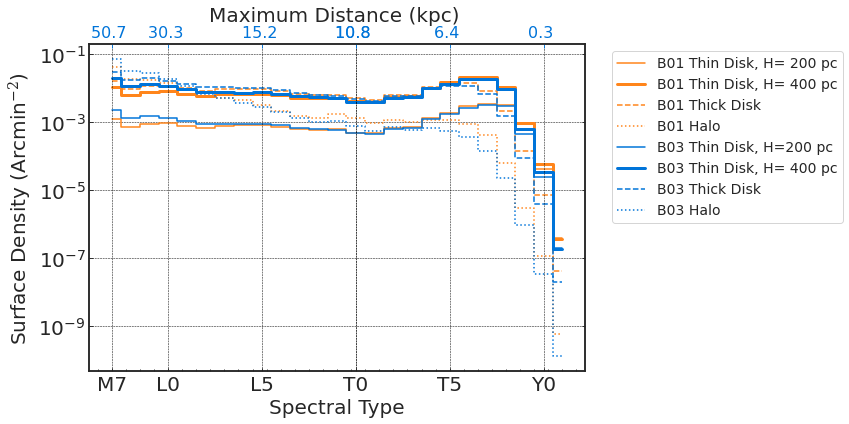

In [20]:
fig, ax=plt.subplots(figsize=(12, 6))
#plt.step(np.arange(17, 42), b97['halo']['counts']*(1/400)*conversion_area,\
#         where='mid',  linestyle='dotted', color='#0074D9', label='B97 Halo')
#plt.step(np.arange(17, 42), b97['thin']['counts']*conversion_area, \
#          where='mid',  linestyle='-', color='#0074D9', label='B97 Thin Disk')
#plt.step(np.arange(17, 42), b97['thick']['counts']*(0.12)*conversion_area, \
#          where='mid',  linestyle='--', color='#0074D9',label='B97 Thick Disk')


plt.step(np.arange(17, 42), b01['thin_200']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#FF851B',  label='B01 Thin Disk, H= 200 pc')

plt.step(np.arange(17, 42), b01['thin_400']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#FF851B',  linewidth=3, label='B01 Thin Disk, H= 400 pc')

plt.step(np.arange(17, 42), b01['thick']['counts']*(0.12)*conversion_area, \
        where='mid', linestyle='--', color='#FF851B',   label='B01 Thick Disk')
plt.step(np.arange(17, 42), b01['halo']['counts']*(1/400)*conversion_area,\
         where='mid',  linestyle='dotted', color='#FF851B', label='B01 Halo')


plt.step(np.arange(17, 42), b03['thin_200']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#0074D9',  label='B03 Thin Disk, H=200 pc')

plt.step(np.arange(17, 42), b03['thin_400']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#0074D9',  linewidth=3, label='B03 Thin Disk, H= 400 pc')

plt.step(np.arange(17, 42), b03['thick']['counts']*(0.12)*conversion_area, \
         where='mid', linestyle='--', color='#0074D9', label='B03 Thick Disk')
plt.step(np.arange(17, 42), b03['halo']['counts']*(1/400)*conversion_area,\
         where='mid', linestyle='dotted', color='#0074D9', label='B03 Halo')


ax.set(xlabel='Spectral Type', \
       ylabel=r'Surface Density (Arcmin$^{-2}$)', xticks=[17, 20, 25, 30, 35, 40],
      xticklabels=['M7', 'L0', 'L5', 'T0', 'T5','Y0'], yscale='log')

ax.grid(False, which='both', axis='x')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([17, 20, 25, 30, 30, 35, 40])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, DIST_LIMITS ), fontsize=16)
ax2.tick_params(colors='#0074D9', which='both') 
ax2.set_xlabel('Maximum Distance (kpc) ')
ax2.grid()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=14)
plt.tight_layout()
ax.grid( axis='y',  which='major')
ax.minorticks_on()
plt.savefig(fig_folder+'/jswt_counts.pdf', dpi=600)

In [21]:
b03['thin_400']['counts']/b03['thin_200']['counts']

array([8.79558561, 8.76747935, 8.68590279, 8.56582933, 8.57736748,
       8.6892765 , 8.50629975, 8.42205299, 8.61156822, 8.55104181,
       8.51533449, 8.55380851, 8.45211276, 8.29955017, 8.50593651,
       8.1299004 , 8.25244236, 8.02463132, 7.69192976, 7.08067694,
       5.8320826 , 3.21807139, 1.42463613, 1.3417927 , 0.94224842])

In [22]:
#number report
num_rp=pd.DataFrame()
#
num_rp['max_distance']= [DIST_LIMITS[x] for x in np.arange(17, 42)]
num_rp['thin_200_b01']= b01['thin_200']['counts']*conversion_area.value
num_rp['thin_200_b03']= b03['thin_200']['counts']*conversion_area.value
num_rp['thin_400_b01']= b01['thin_400']['counts']*conversion_area.value
num_rp['thin_400_b03']= b03['thin_400']['counts']*conversion_area.value

num_rp['thick_b01']=b01['thick']['counts']*(0.12)*conversion_area.value
num_rp['thick_b03']=b03['thick']['counts']*(0.12)*conversion_area.value

num_rp['halo_b01']=b01['halo']['counts']*(1/400)*conversion_area.value
num_rp['halo_b03']=b03['halo']['counts']*(1/400)*conversion_area.value

In [23]:
num_rp['total']= num_rp[['thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].sum(axis=1)

In [24]:
num_rp

,max_distance,thin_200_b01,thin_200_b03,thin_400_b01,thin_400_b03,thick_b01,thick_b03,halo_b01,halo_b03,total
0,50736.363448,1.238598e-03,2.217629e-03,1.078201e-02,1.950535e-02,1.614537e-02,2.918890e-02,4.090908e-02,7.229266e-02,0.192280
1,42645.447536,7.245015e-04,1.302524e-03,6.071957e-03,1.141985e-02,9.233024e-03,1.681862e-02,1.844709e-02,3.223578e-02,0.096253
2,35698.232307,8.891819e-04,1.517673e-03,7.670270e-03,1.318236e-02,1.154206e-02,1.947623e-02,1.752305e-02,2.816352e-02,0.099964
3,30251.318429,9.208272e-04,1.309022e-03,7.916788e-03,1.121286e-02,1.151722e-02,1.640456e-02,1.427924e-02,1.786424e-02,0.081425
4,25888.420581,7.859062e-04,1.078395e-03,6.828686e-03,9.249793e-03,9.800387e-03,1.339062e-02,9.214312e-03,1.111054e-02,0.061459
5,22348.456185,6.623708e-04,8.538054e-04,5.868387e-03,7.418951e-03,8.349771e-03,1.053548e-02,5.690751e-03,6.694306e-03,0.046074
6,19463.715658,7.702300e-04,8.813700e-04,6.550852e-03,7.497198e-03,9.309849e-03,1.050127e-02,5.134189e-03,5.025179e-03,0.045670
7,17121.762257,8.020445e-04,8.666662e-04,6.861523e-03,7.299108e-03,9.349317e-03,9.828012e-03,4.436710e-03,3.708773e-03,0.043152
8,15242.058714,8.045053e-04,8.659956e-04,6.777668e-03,7.457581e-03,9.217587e-03,1.005760e-02,3.147917e-03,2.751787e-03,0.041081
9,13761.911411,7.110089e-04,7.919147e-04,6.174007e-03,6.771695e-03,8.005336e-03,8.710487e-03,2.104121e-03,1.936704e-03,0.035205


In [25]:
num_rp=num_rp.applymap(lambda x: np.round(x, 4))

In [26]:
num_rp['spt']= [splat.typeToNum(x) for x in np.arange(17, 42)]

In [27]:
num_rp.columns

Index(['max_distance', 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03',
       'total', 'spt'],
      dtype='object')

In [30]:
num_rp[['spt', 'max_distance', 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03', 'total']].to_latex('~/desktop/jswt_preds.tex', index=False)